In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import random
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import json

In [2]:
df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
def merge_value(data):
    if data==1 or data==2 or data==3 or data==4:
        return np.int64(1)
    else:
        return np.int64(0)

In [4]:
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR


In [5]:
df['diagnosis'] = df['diagnosis'].apply(merge_value)

In [6]:
diagnosis_dict_btype = {
    0: 'No_DR',
    1: 'DR'
}
df['b_type'] = df['diagnosis'].map(diagnosis_dict_btype.get)
df.head()

,id_code,diagnosis,type,b_type
0,000c1434d8d7,1,Moderate,DR
1,001639a390f0,1,Proliferate_DR,DR
2,0024cdab0c1e,1,Mild,DR
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


1    1857
0    1805
Name: diagnosis, dtype: int64

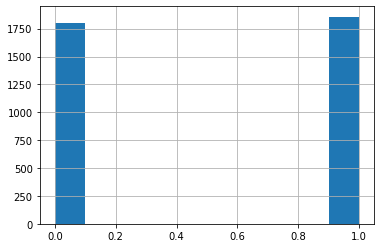

In [7]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

In [8]:
train_intermediate, val = train_test_split(df, test_size = 0.2)
train, test = train_test_split(train_intermediate, test_size = 0.2 / (1 - 0.2))

print(train['diagnosis'].value_counts(), '\n')
print(test['diagnosis'].value_counts(), '\n')
print(val['diagnosis'].value_counts(), '\n')

1    1118
0    1078
Name: diagnosis, dtype: int64 

0    368
1    365
Name: diagnosis, dtype: int64 

1    374
0    359
Name: diagnosis, dtype: int64 



In [9]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [10]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [11]:
src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [12]:
def image_preproc(image):
    image = cv2.resize(image,(224,224))
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    image = tf.image.rgb_to_grayscale(image)
    return image

In [13]:
train_path = './train'
val_path = './val'
test_path = './test'

train_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2196 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


2021-12-09 07:47:20.652064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:47:20.792837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:47:20.793592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:47:20.796410: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


<Figure size 432x288 with 0 Axes>

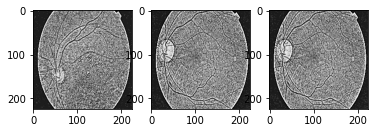

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,40)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0]))

In [15]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3))


219070464/219055592 [==============================] - 1s 0us/step


In [16]:
def build_model():
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    return model

In [17]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches,callbacks=EarlyStopping(monitor="val_loss", patience=10, 
                    restore_best_weights=True))

Epoch 1/50


2021-12-09 07:47:58.854608: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


69/69 [==============================] - 81s 829ms/step - loss: 0.5328 - acc: 0.8051 - val_loss: 0.7714 - val_acc: 0.5484
Epoch 2/50
69/69 [==============================] - 53s 768ms/step - loss: 0.2717 - acc: 0.9057 - val_loss: 0.4600 - val_acc: 0.7858
Epoch 3/50
69/69 [==============================] - 53s 772ms/step - loss: 0.1711 - acc: 0.9403 - val_loss: 0.3716 - val_acc: 0.8377
Epoch 4/50
69/69 [==============================] - 53s 771ms/step - loss: 0.1071 - acc: 0.9649 - val_loss: 0.4086 - val_acc: 0.8063
Epoch 5/50
69/69 [==============================] - 53s 767ms/step - loss: 0.0725 - acc: 0.9781 - val_loss: 0.3568 - val_acc: 0.8554
Epoch 6/50
69/69 [==============================] - 53s 771ms/step - loss: 0.0447 - acc: 0.9877 - val_loss: 0.2892 - val_acc: 0.8977
Epoch 7/50
69/69 [==============================] - 54s 777ms/step - loss: 0.0364 - acc: 0.9904 - val_loss: 0.2392 - val_acc: 0.9291
Epoch 8/50
69/69 [==============================] - 53s 765ms/step - loss: 0.024

<AxesSubplot:>

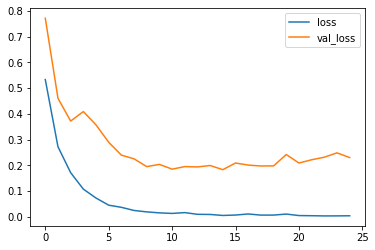

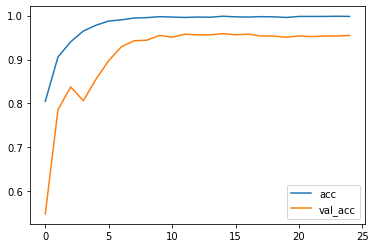

In [19]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [20]:
model.save('InceptionResnetV2New.h5')

In [21]:
from tensorflow.keras.models import load_model
savedModel=load_model('InceptionResnetV2New.h5')

In [22]:
test_eval = savedModel.evaluate(test_batches)
print(f'test loss, test acc: {test_eval}')

23/23 [==============================] - 12s 409ms/step - loss: 0.1651 - acc: 0.9604
test loss, test acc: [0.16510260105133057, 0.9604365825653076]


In [23]:
predictions = savedModel.predict(test_batches)

In [24]:
from sklearn.metrics import confusion_matrix,classification
from sklearn.metrics import classification_report

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
y_pred=predictions.argmax(axis=1)
y_true = test_batches.labels

In [26]:
print(confusion_matrix(y_pred,y_true))
print("\n\n")
print(classification_report(y_pred,y_true))

[[347  11]
 [ 18 357]]



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       358
           1       0.97      0.95      0.96       375

    accuracy                           0.96       733
   macro avg       0.96      0.96      0.96       733
weighted avg       0.96      0.96      0.96       733

